# PV-IN KCNC2 Kv3.2 A new genetic cause of childhood epilepsy


## imports and config

In [1]:
%load_ext autoreload
%autoreload 2
import logging

from pathlib import Path
from functools import lru_cache
from itertools import product
from neuron import h
from neuron import gui
from tqdm import tqdm
from typing import Iterable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.cells.pv_nrn import get_pv, get_pv_params, set_nrn_prop, mut, set_relative_nav11bar

from src.constants import *
from src.settings import *
from src.data import get_cached_df, get_file_path, set_cache_root, get_cache_root, wide_to_long, concise_df
from src.measure import get_max_propagation, get_ap_times, calculate_failures
from src.run import get_trace
from src.utils import get_key, str_to_tuple, nearest_idx, nearest_value, nearest_idx_val, get_last_sec
from src.vis import plot_voltage_trace, set_default_style, save_fig, get_pulse_times, get_pulse_xy
from src.nrn_helpers import init_nrn, env_var

logging.basicConfig(level=logging.INFO)

set_cache_root("D:\\.cache")

init_nrn(celsius=34, v_init=-80) # as in BBP optimisation

h.check_simulator() # method from PV_template.hoc that checks if parameters used during optimisation are the same as those used during simulation

set_default_style()

INFO:nrn_helpers:celsius=34.0 and v_init=-80.0


## Set up point neurons

In [2]:
from nrnutils import Section, Mechanism

# define ion channel parameters
leak = Mechanism("pas", e=-30, g=1e-5)
leak_mut = Mechanism("pas", e=-65, g=1e-5)
# uses ek and has param gSKv3_1bar

kv3 = Mechanism("SKv3_1", a=-2.11, b=-9.7, c=4 * 5, d=10.0, e=8.0)
kv3_mut = Mechanism(
    "SKv3_1m",
    a=-20.0,
    b=-10.2,
    c=4 * 7,
    d=-10.0,
    e=6.0,
)
props = dict(L=30, diam=15, nseg=3, cm=1)
passive_point_neuron = ppn = Section(**props, mechanisms=[leak, kv3], name="WT")
passive_point_neuron_mutant = ppn_mut = Section(
    **props, mechanisms=[leak_mut, kv3_mut], name="C165Y"
)

# change property without creating new neurons/mechanisms
def change_nrn_prop(nrn: Section, prop: str, value: float):
    for seg in nrn:
        setattr(seg, prop, value)


def change_mech_props(nrn: Section, mech="SKv3_1", **prop_value_dict):
    for seg in nrn:
        for prop, value in prop_value_dict.items():
            setattr(getattr(seg, mech), prop, value)


change_nrn_prop(ppn, "ek", -60)
change_nrn_prop(ppn_mut, "ek", -120)

# Objects
t_vec = h.Vector()
v = h.Vector()
v_mut = h.Vector()
ik = h.Vector()
ik_mut = h.Vector()

# record
t_vec.record(h._ref_t)  # only once a section is created
v.record(ppn(0.5)._ref_v)
v_mut.record(ppn_mut(0.5)._ref_v)
ik.record(ppn(0.5)._ref_ik)
ik_mut.record(ppn_mut(0.5)._ref_ik)
vclamp = h.SEClamp(ppn(0.5))
vclamp_mut = h.SEClamp(ppn_mut(0.5))

v_init = env_var()["v_init"]
vclamp.dur1 = vclamp_mut.dur1 = 10
vclamp.dur2 = vclamp_mut.dur2 = 100
vclamp.dur3 = vclamp_mut.dur3 = 100
vclamp.amp1 = vclamp_mut.amp1 = v_init
vclamp.amp2 = vclamp_mut.amp2 = v_init  # this will be changed
vclamp.amp3 = vclamp_mut.amp3 = -40
vclamp.rs = vclamp_mut.rs = 0.01

str(ppn)


"Section(L=30.0, Ra=100.0, nseg=3, rallbranch=1.0, diam=15.0, cm=1.0, mechanisms=[Mechanism(name=pas, parameters={'e': -30, 'g': 1e-05}),Mechanism(name=SKv3_1, parameters={'a': -2.11, 'b': -9.7, 'c': 20, 'd': 10.0, 'e': 8.0})], synapses=[], parent=_)"

## Helpful functions for calculating currents and time constants

In [3]:
def calc_tail_current(ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp):
    """
    Calculates tail current for a given vclamp value
    """
    tail_current = np.mean(
        ik_np[
            (t_np > (vclamp.dur2 + vclamp.dur1))
            & (t_np < (vclamp.dur2 + vclamp.dur1 + 10))
        ]
    )
    return tail_current


def calc_activation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates activation time constant for a given vclamp value
    """
    rise_idx = np.where((t_np > vclamp.dur1) & (t_np < (vclamp.dur2 + vclamp.dur1)))[0]
    activation_ik = ik_np[rise_idx]

    # find idx for 1-1/e of max
    idx = nearest_idx(activation_ik, activation_ik[-1] * (1 - np.exp(-1)))
    return t_np[rise_idx[0] + idx] - t_np[rise_idx[0]]


def calc_deactivation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates deactivation time constant for a given vclamp value
    """
    decay_idx = np.where(
        (t_np > (vclamp.dur2 + vclamp.dur1))
        & (t_np <= (vclamp.dur2 + vclamp.dur1 + vclamp.dur3))
    )[0]
    # find idx for 1/e of max
    tail_ik_np = ik_np[decay_idx]
    t_idx = int(0.5//h.dt)
    is_decay = (tail_ik_np[t_idx] - tail_ik_np[-1]) > 0
    if is_decay:
        idx = nearest_idx(tail_ik_np, tail_ik_np[t_idx] * np.exp(-1))
    else:
        idx = nearest_idx(tail_ik_np, tail_ik_np[t_idx] * (1 - np.exp(-1)))
    return t_np[decay_idx[0] + idx] - t_np[decay_idx[0]]

def interpolate(points: pd.DataFrame, step_size: float) -> float:
    """
    Interpolate a point in a line.
    """
    interp_points = points.reindex(index=np.arange(points.index.min(), points.index.max()+1, step_size))
    interp_points = interp_points.interpolate(method="linear", limit_direction="both")
    return interp_points


def find_v_half(points: pd.DataFrame):

    # find v 1/2 point for peak ik
    idx = nearest_idx(points["peak ik"].values, points["peak ik"].max()/2)
    v_half_peak = points.iloc[idx]["v"]
    return idx, v_half_peak


## Voltage clamp IV curve

100%|██████████| 111/111 [00:02<00:00, 39.38it/s]


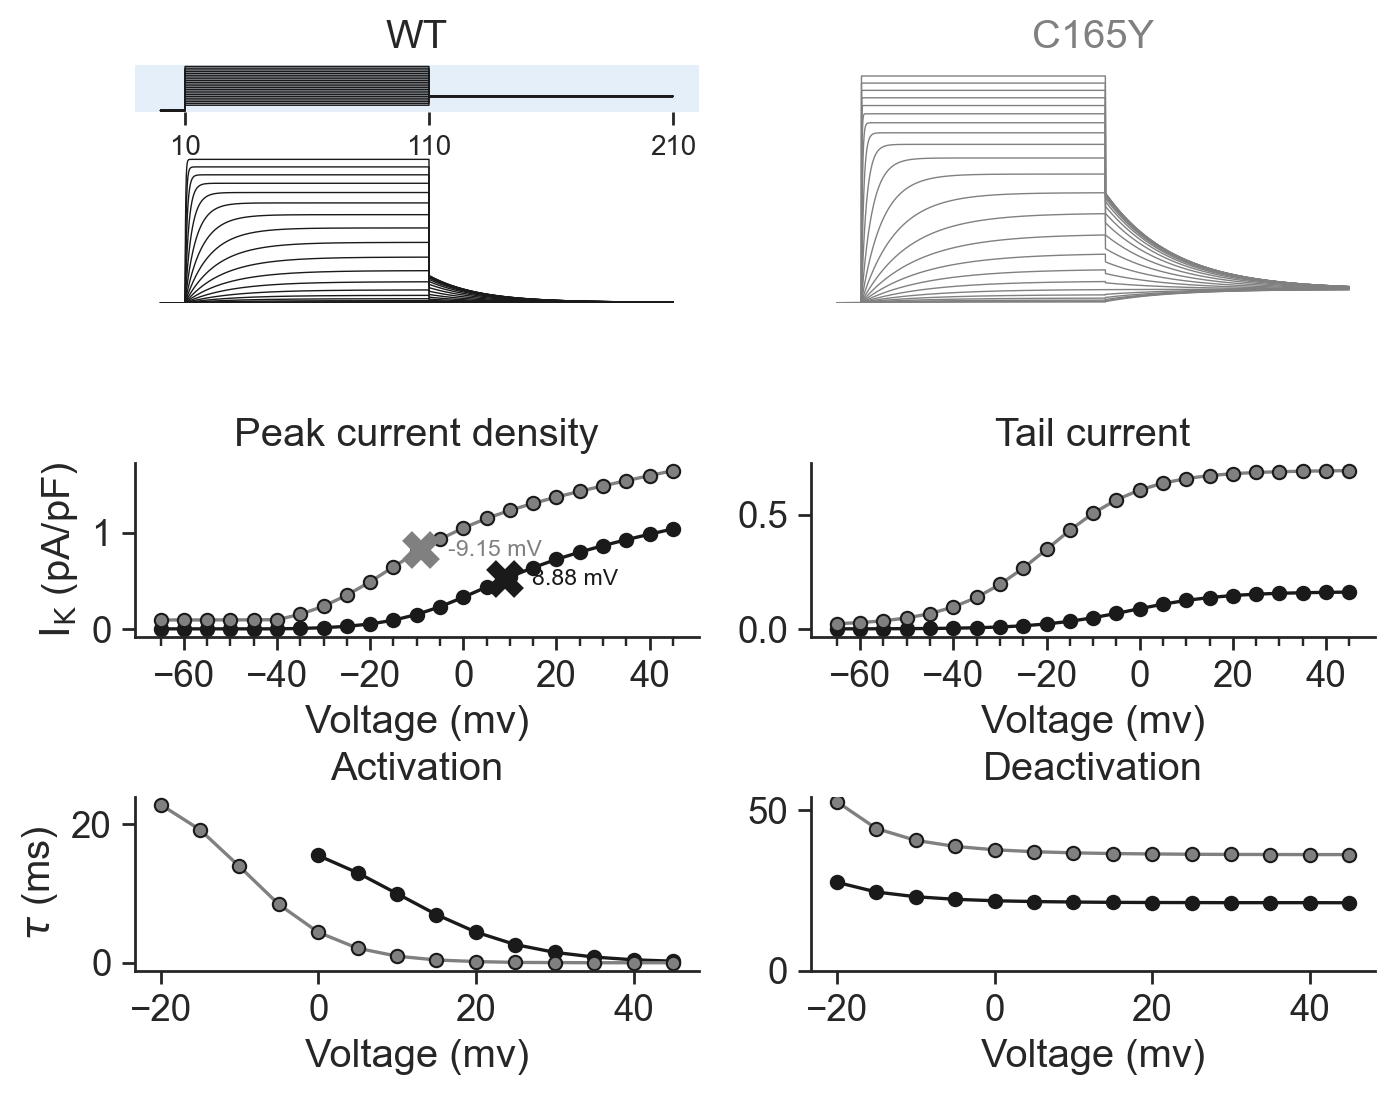

In [4]:
def iv_fig(vclamp_values=None, ppn_props=None, ppn_mut_props=None, tstop=210):
    """
    Plots IV curve for the ppn and ppn_mut point neurons.

    **Note** that ppn_props permantly changes the properties of the ppn point neuron.

    """
    if vclamp_values is None:
        vclamp_values = np.arange(-65, 50, 5)
    ppn_props = ppn_props or {}
    ppn_mut_props = ppn_mut_props or {}

    h.tstop = max(tstop, vclamp.dur1 + vclamp.dur2 + vclamp.dur3)

    points = pd.DataFrame()

    extended_vclamp_values = np.arange(vclamp_values.min(), vclamp_values.max() + 1, 1)

    change_mech_props(ppn, **ppn_props)
    change_mech_props(ppn_mut, "SKv3_1m", **ppn_mut_props)

    sample_lines = {
        "v": [],
        "ik": [],
        "ik_mut": [],
    }

    for amp in tqdm(extended_vclamp_values):
        vclamp.amp2 = vclamp_mut.amp2 = amp

        h.finitialize(env_var()["v_init"])
        h.run()

        t_np = t_vec.as_numpy()
        v_np = v.as_numpy()
        ik_np = ik.as_numpy()
        v_mut_np = v_mut.as_numpy()
        ik_mut_np = ik_mut.as_numpy()

        if amp in vclamp_values:
            sample_lines["v"].append(np.array(v_np))  # copy data
            sample_lines["ik"].append(np.array(ik_np))
            sample_lines["ik_mut"].append(np.array(ik_mut_np))

        points = pd.concat(
            [
                points,
                pd.DataFrame(
                    {
                        "v": [vclamp.amp2, vclamp_mut.amp2],
                        "peak ik": [max(ik_np), max(ik_mut_np)],
                        "tail ik": [
                            calc_tail_current(ik_np, t_np, vclamp),
                            calc_tail_current(ik_mut_np, t_np, vclamp_mut),
                        ],
                        "tau activation": [
                            calc_activation_time_constant_tau(ik_np, t_np, vclamp),
                            calc_activation_time_constant_tau(
                                ik_mut_np, t_np, vclamp_mut
                            ),
                        ],
                        "tau deactivation": [
                            calc_deactivation_time_constant_tau(ik_np, t_np, vclamp),
                            calc_deactivation_time_constant_tau(
                                ik_mut_np, t_np, vclamp_mut
                            ),
                        ],
                        "Kv3.2": [ppn.name(), ppn_mut.name()],
                    },
                    # index=[0, 1], # only needed if single row
                ),
            ],
            ignore_index=True,
        )

    # clean up dataframe
    # convert ik in mA/cm2 to pA/pF using membrane capacitance (uF/cm2)
    points["peak ik"] = points["peak ik"] * 1e3 / ppn.cm
    points["tail ik"] = points["tail ik"] * 1e3 / ppn.cm

    pal = sns.color_palette("Blues", len(vclamp_values))
    sns.set_palette("Blues", len(vclamp_values))
    sns.set_context("paper", font_scale=1.5)

    fig, axes = plt.subplot_mosaic(
        [
            ["ik", "ik_mut"],
            ["ik", "ik_mut"],
            ["i-v peak", "i-v tail"],
            ["tau activation", "tau deactivation"],
        ],
        gridspec_kw={"height_ratios": [0.4, 0.5, 2, 2], "hspace": 1.5},
        dpi=200,
        figsize=(8, 6),
    )
    # create inset axis
    axes["v"] = axes["ik"].inset_axes([0.0, 0.8, 1.0, 0.2])

    # plot sample lines
    for key in sample_lines.keys():
        c = "gray" if "mut" in key else "k"
        for i, line in enumerate(sample_lines[key]):
            axes[key].plot(t_np, line, lw=0.5, c=c)

    # take only vclamp values
    plot_points = points[points["v"].isin(vclamp_values)]

    VOLTAGE_MV = "Voltage (mv)"

    sns.lineplot(
        data=plot_points,
        x="v",
        y="peak ik",
        ax=axes["i-v peak"],
        hue="Kv3.2",
        palette=["k", "gray"],
        marker="o",
        markeredgecolor="k",
        legend=False,
    )
    sns.lineplot(
        data=plot_points,
        x="v",
        y="tail ik",
        ax=axes["i-v tail"],
        hue="Kv3.2",
        palette=["k", "gray"],
        marker="o",
        markeredgecolor="k",
        legend=False,
    )

    # plot voltage at half peak
    for key, c in zip(["WT", "C165Y"], ["k", "gray"]):
        df_kv = points[points["Kv3.2"] == key].reset_index()
        interp_points = interpolate(df_kv, 0.01)
        df_kv["Relative conductance"] = df_kv["peak ik"] / df_kv["peak ik"].max()
        interp_points["Relative conductance"] = (
            interp_points["peak ik"] / interp_points["peak ik"].max()
        )

        v_half_idx, v_half = find_v_half(interp_points)
        # print(f"{v_half=}")
        xy = (v_half, interp_points.iloc[v_half_idx]["peak ik"])
        axes["i-v peak"].annotate(
            f"{xy[0]:.2f} mV",
            xy=xy,
            xytext=(10, 0),
            textcoords="offset points",
            color=c,
            # arrowprops=dict(arrowstyle="->", color="k"),
            va="center",
            fontsize="xx-small",
        )

        axes["i-v peak"].plot(
            *xy, "x", color=c, markersize=10, markeredgewidth=5, zorder=100
        )

    axes["v"].set_ylim(env_var()["v_init"] - 5, max(vclamp_values) + 5)
    # set ylims the same for ik and ikmut
    ymax = max(axes["ik"].get_ylim()[1], axes["ik_mut"].get_ylim()[1])
    for ax in [axes["ik"], axes["ik_mut"]]:
        ax.set_ylim(0, ymax)

    axes["ik"].set_title(ppn.name())
    axes["ik_mut"].set_title(ppn_mut.name(), color="gray")

    axes["i-v peak"].set_title("Peak current density")
    axes["i-v tail"].set_title("Tail current")

    for ax in [axes["v"], axes["ik"], axes["ik_mut"]]:
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set(yticks=[], xticks=[])

    xticks = [
        vclamp.dur1,
        vclamp.dur1 + vclamp.dur2,
        vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
    ]
    axes["v"].set_xticks(xticks)
    axes["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

    # sns.despine(ax=axes["v"], top=False, right=False)
    pal = sns.color_palette("Blues", n_colors=10)
    axes["v"].set_facecolor(pal[0])

    for ax in [axes["i-v peak"], axes["i-v tail"]]:
        ax.set_xlabel(VOLTAGE_MV)
        if ax == axes["i-v peak"]:
            ax.set_ylabel("$\\rm{I_{K}}$ (pA/pF)")
        else:
            ax.set_ylabel("")
        ax.set_xticks(plot_points["v"], minor=True)
        ax.set_xticks(
            np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 20), minor=False
        )

    for i, key in enumerate(["tau activation", "tau deactivation"]):
        min_v = -20 if "deactivation" in key else 0
        sns.lineplot(
            data=plot_points[
                (
                    ((plot_points["v"] >= min_v) & (plot_points["Kv3.2"] == "WT"))
                    | ((plot_points["v"] >= -20) & (plot_points["Kv3.2"] == "C165Y"))
                )
            ],
            x="v",
            y=key,
            ax=axes[key],
            hue="Kv3.2",
            hue_order=["WT", "C165Y"],
            palette=["k", "gray"],
            marker="o",
            markeredgecolor="k",
            legend=False,
        )
        axes[key].set_title(key.replace("tau ", "").capitalize())
        axes[key].set_xlabel(VOLTAGE_MV)
        if key == "tau activation":
            axes[key].set_ylabel(f"$\\tau$ (ms)")
        else:
            axes[key].set_ylabel("")

    # axes["tau activation"].set_ylim(0, 40)
    axes["tau deactivation"].set_ylim(0)

    return points, plot_points


iv_fig();


## PV Interneuron

In [5]:
pv = get_pv()

In [6]:
### create method for running multiple simulations
def run_sims(pv, stims, fractions, dur, load=False, arrow=False):
    # note that we 'tuple' the product generator to convert it to an iterable of known length for the progressbar
    pbar = tqdm(tuple(product(stims, fractions)))
    
    results = {}
    
    for stim, frac in pbar:
        amp, freq = stim
        key_name = get_key(pv, frac, stim, dur)
        pbar.set_description(f"{key_name}")

        path = get_file_path(key_name)
        long_format_path = get_file_path(key_name, ext="arrow")

        x_df = None
        if not path.exists():
            pbar.set_description(f"{key_name} running")
            
            pv.biophys()
            mut(pv, frac)

            # run sim and save results
            AP, x_df = get_cached_df(key_name, pv, amp, dur, stim_freq=freq, shape_plot=True)

        if arrow and not long_format_path.exists():
            """Save in .feather format, to be loaded using vaex and arrow"""
            if x_df is None:
                # load results
                pbar.set_description(f"{key_name} loading")
                AP, x_df = get_cached_df(key_name)
            # format data
            long_df = wide_to_long(x_df)
            # add metadata as columns with uniform data along the rows
            long_df[KVMUT_FRAC_LABEL] = frac
            long_df[CURRENT_LABEL] = amp
            long_df["Stim. duration"] = dur
            long_df[STIM_FREQ_LABEL] = freq
            long_df["key"] = key_name

            # save
            pbar.set_description(f"{key_name} saving")
            long_df.to_feather(long_format_path)
        
        if load:
            if x_df is None:
                # load results
                pbar.set_description(f"{key_name} loading")
                AP, x_df = get_cached_df(key_name)
            # store in dict
            results[key_name] = {
                                "df": wide_to_long(x_df),
                                KVMUT_FRAC_LABEL: frac,
                                CURRENT_LABEL: amp,
                                "Stim. duration": dur,
                                STIM_FREQ_LABEL: freq,
                                "APCount": AP
                               }
        
        pbar.set_description(f"done")

    return results
    

In [22]:
# I-F curve

stims = [(amp, 0) for amp in np.round(np.arange(0.1, 4.1, 0.2), 2)]

fractions = np.round(np.arange(0, 1.01, 0.25), 2)

amp_result = run_sims(pv, stims, fractions, dur=500, load=True, arrow=True)
amp_result

done: 100%|██████████| 100/100 [09:28<00:00,  5.69s/it]                                                             


{'WT_default(1000.0, 30.0, 1.0, 60.0)_(0.1, 0)_500': {'df':          Time (ms)   Section  Distance from soma (μm)  Membrane potential (mV)
  0              0.0   soma[0]                      0.0                    -80.0
  1          0.00012   soma[0]                      0.0               -80.000011
  2          0.00046   soma[0]                      0.0                -80.00004
  3          0.00134   soma[0]                      0.0               -80.000097
  4         0.003613   soma[0]                      0.0               -80.000179
  ...            ...       ...                      ...                      ...
  220820  488.245433  node[32]              1094.757928               -68.239703
  220821  501.530153  node[32]              1094.757928               -68.237326
  220822  514.814873  node[32]              1094.757928                -68.23988
  220823       520.0  node[32]              1094.757928               -68.240633
  220824       520.0  node[32]              1094.75

In [23]:

ap_df = pd.DataFrame()

for key, val in amp_result.items():
    nrn_name = key[: key.find("_")]
    df = val["df"]
    frac = val[KVMUT_FRAC_LABEL]
    current = val[CURRENT_LABEL]
    ap_soma = val["APCount"]["soma"].n
    ap_axon = val["APCount"]["comm"].n

    ap_df = pd.concat(
        [
            ap_df,
            pd.DataFrame(
                {
                    KVMUT_FRAC_LABEL: val[KVMUT_FRAC_LABEL],
                    CURRENT_LABEL: val[CURRENT_LABEL],
                    "Neuron": nrn_name,
                    "loc": ["soma", "axon"],
                    "Spikes": [ap_soma, ap_axon],
                },
            ),
        ],
        ignore_index=True,
    )
ap_df

,Kv3.2 mutant fraction,Current (nA),Neuron,loc,Spikes
0,0.00,0.1,WT,soma,0.0
1,0.00,0.1,WT,axon,0.0
2,0.25,0.1,C165Y - 25%,soma,0.0
3,0.25,0.1,C165Y - 25%,axon,0.0
4,0.50,0.1,C165Y - 50%,soma,0.0
...,...,...,...,...,...
195,0.50,3.9,C165Y - 50%,axon,1.0
196,0.75,3.9,C165Y - 75%,soma,1.0
197,0.75,3.9,C165Y - 75%,axon,1.0
198,1.00,3.9,C165Y - 100%,soma,1.0


<AxesSubplot:xlabel='Current (nA)', ylabel='Spikes'>

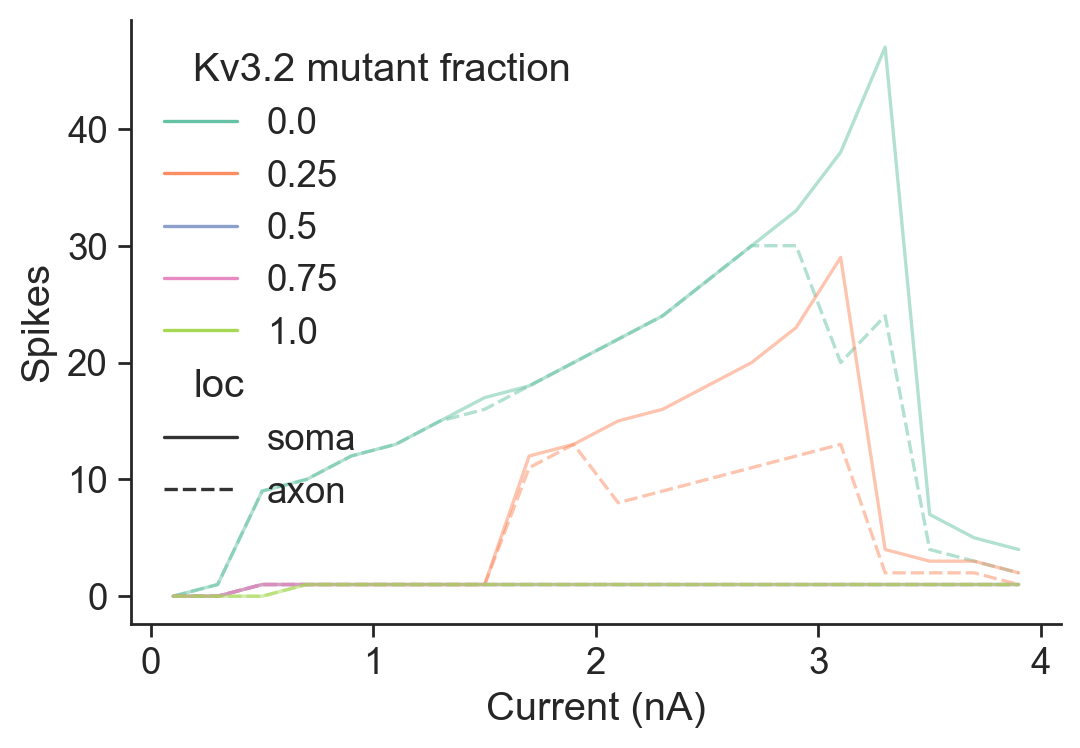

In [24]:
sns.lineplot(
    data=ap_df,
    x=CURRENT_LABEL,
    y="Spikes",
    hue=KVMUT_FRAC_LABEL,
    palette="Set2",
    style="loc",
    alpha=0.5,
)

In [25]:
amp = 2  # nA
dur = 1000  # ms

pv_wt = get_pv("WT")

pv_mut_1 = get_pv("C165Y - 25%")
mut(pv_mut_1, 0.25)
    
# create datafrome for voltage at nodes
v_df = pd.DataFrame()

for nrn in [
    pv_wt,
    pv_mut_1,
    # pv_mut_3_4, pv_mut_half, pv_mut_quart
]:
    # set_nrn_prop(nrn, "ek", -85, ignore_error=True)
    t, v, AP, x_df = get_trace(nrn, amp, dur, shape_plot=True)
    soma = x_df.iloc[:, 0]
    tip = x_df.iloc[:, -1]
    v_df = pd.concat(
        [
            v_df,
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: tip.values,
                    TIME_LABEL: tip.index,
                    "Neuron": nrn.name[: nrn.name.find("(")],
                    "loc": "tip",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: soma.values,
                    TIME_LABEL: soma.index,
                    "Neuron": nrn.name[: nrn.name.find("(")],
                    "loc": "soma",
                },
            ),
        ],
        ignore_index=True,
    )

v_df


,Membrane potential (mV),Time (ms),Neuron,loc
0,-80.000000,0.000000,WT,tip
1,-80.000013,0.000077,WT,tip
2,-79.999933,0.000264,WT,tip
3,-79.999595,0.000679,WT,tip
4,-79.998707,0.001540,WT,tip
...,...,...,...,...
51111,-49.587821,1015.932927,C165Y - 25%,soma
51112,-48.195195,1017.564804,C165Y - 25%,soma
51113,-46.794370,1019.196681,C165Y - 25%,soma
51114,-46.080646,1020.000000,C165Y - 25%,soma


<AxesSubplot:xlabel='Time (ms)', ylabel='Membrane potential (mV)'>

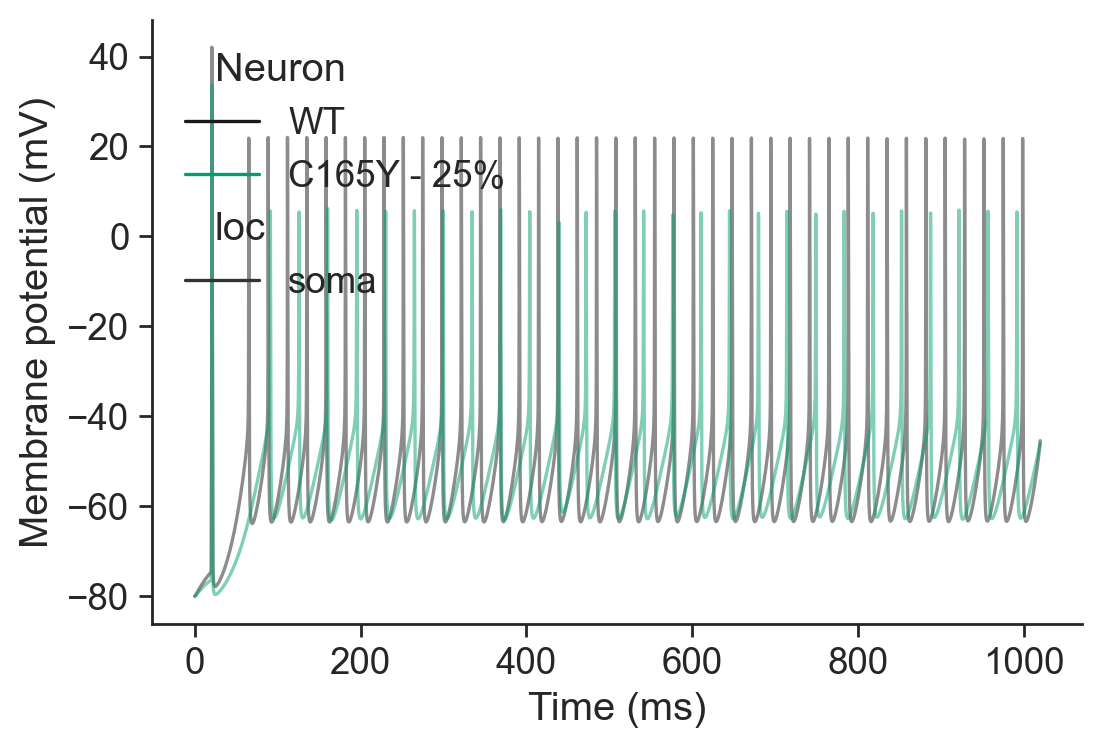

In [56]:

sns.lineplot(
    data=v_df,
    x=TIME_LABEL,
    y=VOLTAGE_LABEL,
    hue="Neuron",
    hue_order=["WT", "C165Y - 25%"],
    palette=['k', 'g'],
    style="loc",
    style_order=["soma"],
    alpha=0.5,
)
